# What is transfer learning?

Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as ImageNet (millions of images of different objects) and use them to power our FoodVision Mini model.


# Why use transfer learning?

There are two main benefits to using transfer learning:

- Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
- Can leverage a working model which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.


# Getting setup


In [2]:
pip install torchinfo

In [3]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models import list_models
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Get data


In [5]:
import requests
import zipfile
from pathlib import Path

# Define paths
data_path = Path("data/")  # Folder where data will be extracted
zip_folder_path = data_path / "pizza_steak_sushi.zip"

# Create the data directory if it doesn't exist
data_path.mkdir(parents=True, exist_ok=True)

# Download the zip file
response = requests.get(
    "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")

# Should print 200 if OK
print(f"Download Status Code: {response.status_code}")

# Save the zip file
with open(zip_folder_path, "wb") as f:
    f.write(response.content)

print(f"Saved zip file to: {zip_folder_path}")

# Extract the zip file
with zipfile.ZipFile(zip_folder_path, "r") as zip_ref:
    zip_ref.extractall(data_path/'food_dataset')

print(f"Extracted zip file to: {data_path}")

Download Status Code: 200
Saved zip file to: data/pizza_steak_sushi.zip
Extracted zip file to: data


In [6]:
train_dir = data_path/'food_dataset'/'train'
test_dir = data_path/'food_dataset'/'test'

# Create Datasets and DataLoaders

we'll be using a pretrained model from torchvision.models, there's a specific transform we need to prepare our images first.


## Creating a transform for torchvision.models(manually)

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

some pretrained models from torchvision.models in different sizes to [3, 224, 224], for example, some might take them in [3, 240, 240]. For specific input image sizes.

Where did the mean and standard deviation values come from? Why do we need to do this?

These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.

We also don't need to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.


In [7]:
# create transform plipline manually
manually_transform = transforms.Compose([
    # resize images to 224 height and 224 width
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(), 				# convert them into tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
                         std=[0.229, 0.224, 0.225])
])

In [8]:
# Load data using torchvision datasets
train_data = datasets.ImageFolder(
    train_dir,   				       # train data path to load data
    transform=manually_transform,  # transforming traning data
    # tranform to apply to the target labels (not used here)
    target_transform=None
)

test_data = datasets.ImageFolder(
    test_dir,   				       # test data path to load data
    transform=manually_transform,  # transforming traning data
    # tranform to apply to the target labels (not used here)
    target_transform=None
)

In [9]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/food_dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [11]:
num_classes = train_data.classes

In [12]:
num_classes

['pizza', 'steak', 'sushi']

In [13]:
# turn data into data loaders
import os
train_data_loader = DataLoader(
    dataset=train_data,  # traning data
    batch_size=32,		# traning batch size 32 images in a batch
    shuffle=True,			# shuffle the data at every epoch
    num_workers=os.cpu_count()  # number of subprocesses to use for data loading
)

test_data_loader = DataLoader(
    dataset=test_data,  # testing data
    batch_size=32,		# testing batch size 32 images in a batch
    shuffle=False,			# shuffle the data at every epoch
    num_workers=os.cpu_count()  # number of subprocesses to use for data loading
)

In [14]:
train_data_loader.num_workers

2

In [15]:
train_data_loader, test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7b796cb81a10>,
 <torch.utils.data.dataloader.DataLoader at 0x7b7a98627c10>)

## Creating a transform for torchvision.models (auto creation)


when using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.

torchvision v0.13+, an automatic transform creation feature has been added.

When you setup a model from torchvision.models and select the pretrained model weights you'd like to use, for example, say we'd like to use:

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT


EfficientNet_B0_Weights is the model architecture weights we'd like to use (there are many different model architecture options in torchvision.models).
DEFAULT means the best available weights (the best performance in ImageNet).
Note: Depending on the model architecture you choose, you may also see other options such as IMAGENET_V1 and IMAGENET_V2 where generally the higher version number the better. Though if you want the best available, DEFAULT is the easiest option


In [16]:
# get pretrain model weights
import torchvision
# .DEFAULT = best available weights from pretraining on ImageNet
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [17]:
# Get the transforms used to create our pretrained weights
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

**Note :** auto_transforms is very similar to manual_transforms, the only difference is that auto_transforms came with the model architecture we chose, where as we had to create manual_transforms by hand.

The benefit of automatically creating a transform through weights.transforms() is that you ensure you're using the same data transformation as the pretrained model used when it was trained.


In [18]:
# Load data using torchvision datasets
train_data_auto = datasets.ImageFolder(
    train_dir,   				       # train data path to load data
    transform=auto_transform,     # transforming traning data
    # tranform to apply to the target labels (not used here)
    target_transform=None
)

test_data_auto = datasets.ImageFolder(
    test_dir,   				       # test data path to load data
    transform=auto_transform,     # transforming testing data
    # tranform to apply to the target labels (not used here)
    target_transform=None
)

In [19]:
# turn data into data loaders
import os
train_data_loader_auto = DataLoader(
    dataset=train_data_auto,  # traning data
    batch_size=32,		# traning batch size 32 images in a batch
    shuffle=True,			# shuffle the data at every epoch
    num_workers=os.cpu_count()  # number of subprocesses to use for data loading
)

test_data_loader_auto = DataLoader(
    dataset=test_data_auto,  # testing data
    batch_size=32,		# testing batch size 32 images in a batch
    shuffle=False,			# shuffle the data at every epoch
    num_workers=os.cpu_count()  # number of subprocesses to use for data loading
)

# Pretrained model


In [20]:
list_model = list_models()
print(list_model)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', 'quantized_mobilenet_v2

In [21]:
list_model.count('alexnet')

1

In [22]:
len(list_model)

121

Which pretrained model should you use?
It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7()) means better performance but a larger model.

Question arise bigger model performance is always better, right?

That's true but some better performing models are too big for some devices.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, you'd likely take the biggest, most compute hungry model you can.


## Setting up a pretrained model


![EfficientNet Feature Extractor](E:/python/pytorch/img/06-effnet-b0-feature-extractor.png)


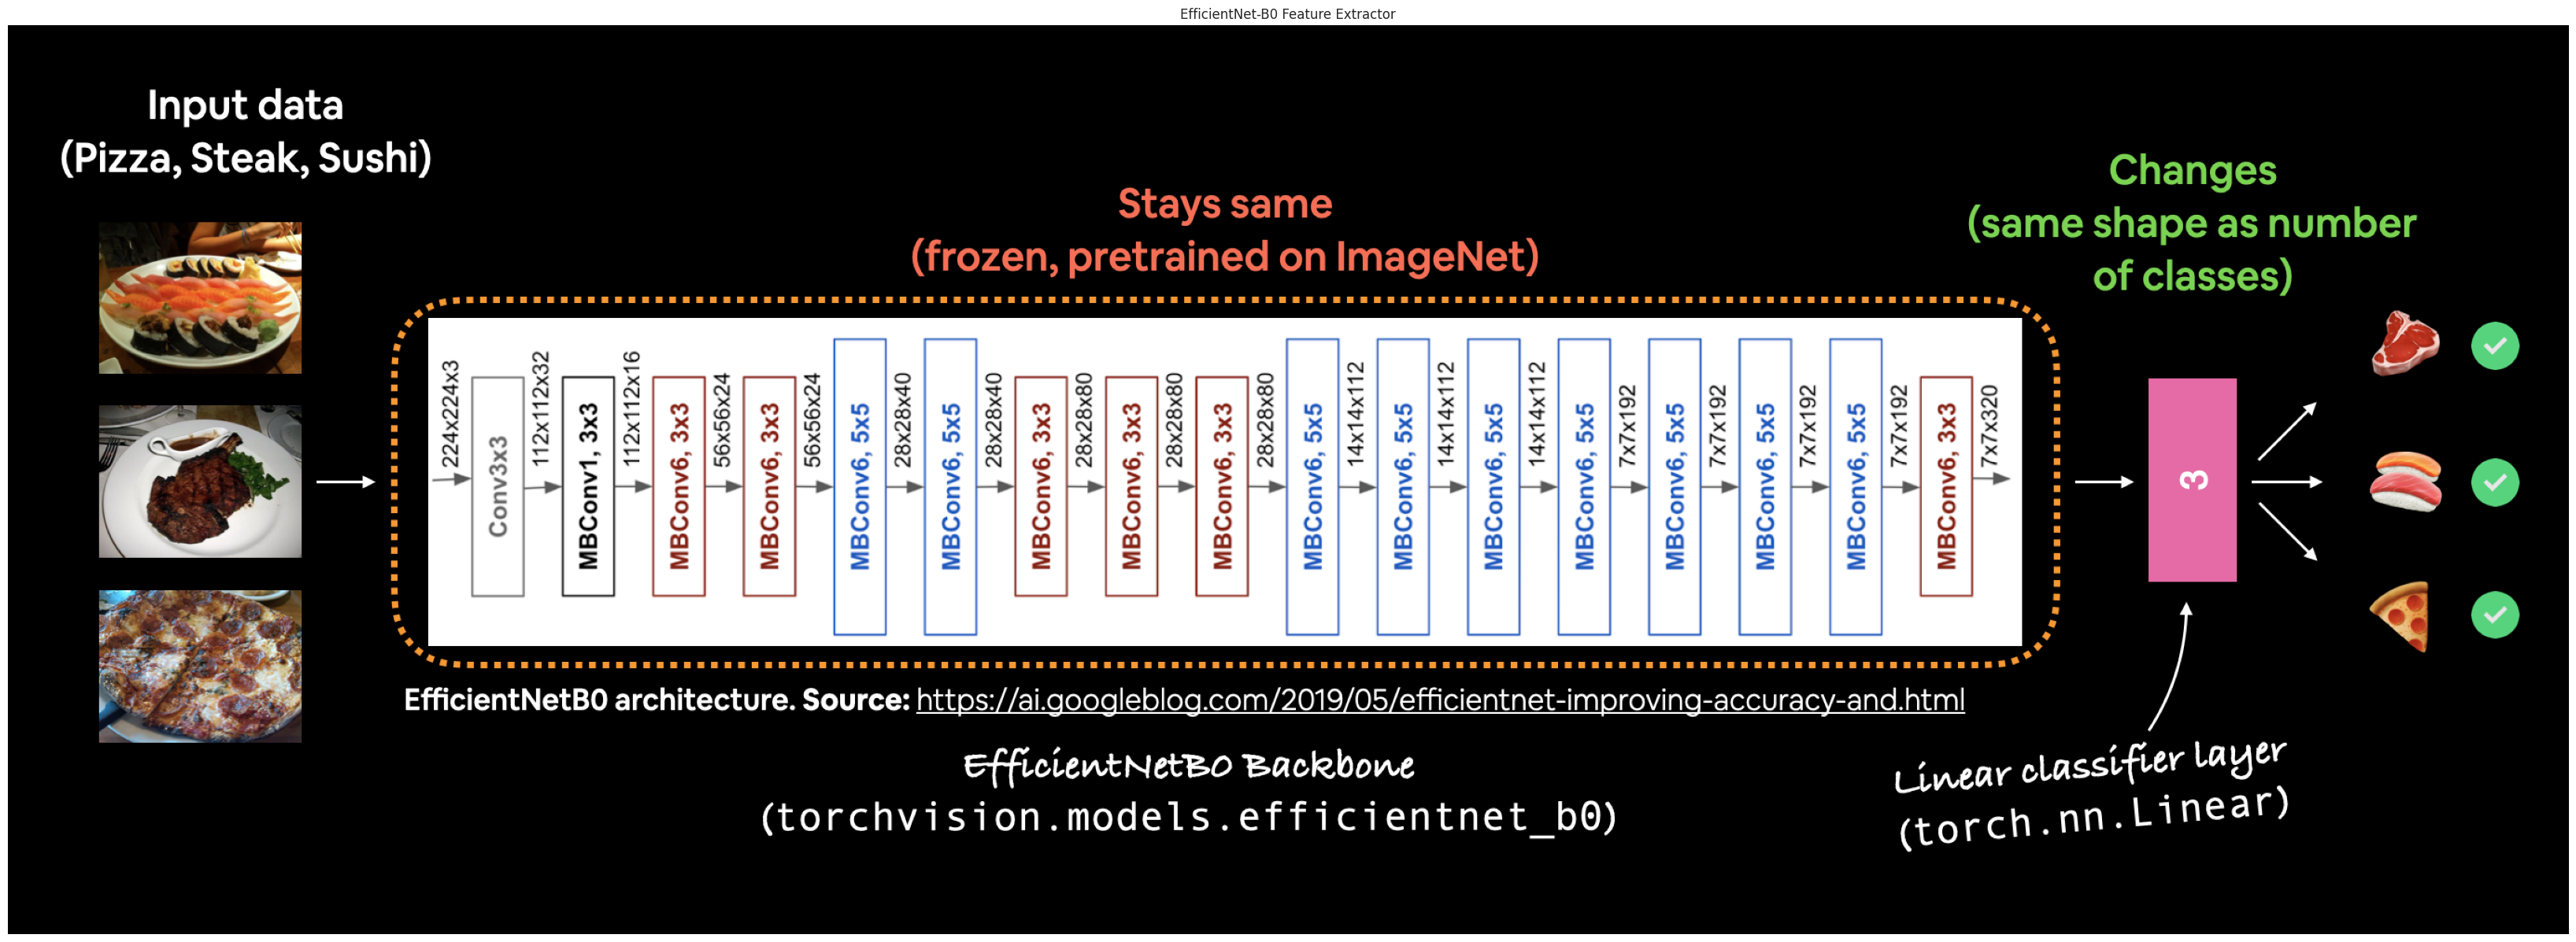

In [25]:
from PIL import Image

# Load the image
img_path = r"/content/06-effnet-b0-feature-extractor.png"
img = Image.open(img_path)

# Display the image
plt.figure(figsize=(112, 15))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title('EfficientNet-B0 Feature Extractor')
plt.show()

In [26]:
# old setup model with pretrain weights
# model = torchvision.models.EfficientNet_B0_Weights(pretrained=True).to(device)

# new setup model with pretrain weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 103MB/s]


In [27]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [28]:
summary(
    model,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## Freezing the base model and changing the output layer to suit our needs

Let's freeze all of the layers/parameters in the features section of our efficientnet_b0 model.

To freeze layers means to keep them how they are during training. For example, if your model has pretrained layers, to freeze them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

For parameters with requires_grad=False, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.


In [29]:
for param in model.features.parameters():
    param.requires_grad = False

In [30]:
output_chape = len(num_classes)

# recreate classifier layer
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=output_chape, bias=True)
).to(device)

In [31]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Let's go through them:

Trainable column - You'll see that many of the base layers (the ones in the features portion) have their Trainable value as False. This is because we set their attribute requires_grad=False. Unless we change this, these layers won't be updated during future training.

Output shape of classifier - The classifier portion of the model now has an Output Shape value of [32, 3] instead of [32, 1000]. It's Trainable value is also True. This means its parameters will be updated during training. In essence, we're using the features portion to feed our classifier portion a base representation of an image and then our classifier layer is going to learn how to base representation aligns with our problem.

Less trainable parameters - Previously there were 5,288,548 trainable parameters. But since we froze many of the layers of the model and only left the classifier as trainable, there's now only 3,843 trainable parameters (even less than our TinyVGG model). Though there's also 4,007,548 non-trainable parameters, these will create a base representation of our input images to feed into our classifier layer.


Note: The more trainable parameters a model has, the more compute power/longer it takes to train. Freezing the base layers of our model and leaving it with less trainable parameters means our model should train quite quickly. This is one huge benefit of transfer learning, taking the already learned parameters of a model trained on a problem similar to yours and only tweaking the outputs slightly to suit your problem.


# Train model


In [32]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
def train_step(
        model: nn.Module,
        dataloader: DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: nn.Module,
        device:torch.device
    ):
    # model to train mode
    model.train()
    total_loss, total_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        output = model(x)  # forward pass
        loss = loss_fn(output, y)  # calculate loss
        total_loss += loss.item()
        # optimizer
        optimizer.zero_grad()  # reset gradient

        # loss backward
        loss.backward()

        # update weights
        optimizer.step()
        # calculate label and accuracy
        y_pred_label = torch.argmax(output, dim=1)
        total_acc += (y_pred_label == y).sum().item() / len(output)

    total_loss /= len(dataloader)
    total_acc /= len(dataloader)
    return total_acc, total_loss , model

In [34]:
def test_step(
        model: nn.Module,
        dataloader: DataLoader,
        loss_fn: nn.Module,
        device: torch.device
    ):
    # model to eval mode
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            # forward pass
            output = model(x)
            # calculate loss
            loss = loss_fn(output, y)
            test_loss += loss.item()
            # predict label and accuracy
            y_pred_label = torch.argmax(output, dim=1)
            test_acc += (y_pred_label == y).sum().item() / len(output)

    test_acc /= len(dataloader)
    test_loss /= len(dataloader)
    return  test_acc, test_loss, model



In [35]:
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader

def model_engine(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    device: torch.device,
    epochs: int
):

    # Results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Training and testing loop
    for epoch in tqdm(range(epochs)):
        train_acc, train_loss, model = train_step(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            device=device
        )

        test_acc, test_loss, model = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(f"Epoch: {epoch+1} | Train_loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} | Test_loss: {test_loss:.4f} | Test_acc: {test_acc:.4f}")

        # Update results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results, model


## EfficientNet Traning

In [42]:
# start timer
from timeit import default_timer as Timer
start_timer = Timer()

# setup traning and svae result and model manully transform data

results , model_effienvtnet_v2 = model_engine(
    model=model,
    train_dataloader=train_data_loader,
    test_dataloader=test_data_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50,
    device=device
)

torch.save(obj=model.state_dict(),f='Models/efficientnet.pth')
# End the timer and print out how long it took
end_time = Timer()
print(f"[INFO] Total training time: {end_time-start_timer:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Train_loss: 0.1614 | Train_acc: 0.9922 | Test_loss: 0.2688 | Test_acc: 0.9384
Epoch: 2 | Train_loss: 0.1945 | Train_acc: 0.9805 | Test_loss: 0.2732 | Test_acc: 0.9384
Epoch: 3 | Train_loss: 0.2396 | Train_acc: 0.8633 | Test_loss: 0.2827 | Test_acc: 0.9280
Epoch: 4 | Train_loss: 0.1789 | Train_acc: 0.9961 | Test_loss: 0.2578 | Test_acc: 0.9384
Epoch: 5 | Train_loss: 0.2210 | Train_acc: 0.9766 | Test_loss: 0.2659 | Test_acc: 0.9489
Epoch: 6 | Train_loss: 0.1686 | Train_acc: 0.9883 | Test_loss: 0.2453 | Test_acc: 0.9384
Epoch: 7 | Train_loss: 0.1715 | Train_acc: 0.9961 | Test_loss: 0.2890 | Test_acc: 0.9384
Epoch: 8 | Train_loss: 0.3518 | Train_acc: 0.8672 | Test_loss: 0.3293 | Test_acc: 0.9176
Epoch: 9 | Train_loss: 0.2120 | Train_acc: 0.8672 | Test_loss: 0.2720 | Test_acc: 0.9384
Epoch: 10 | Train_loss: 0.2770 | Train_acc: 0.8711 | Test_loss: 0.2592 | Test_acc: 0.9072
Epoch: 11 | Train_loss: 0.2617 | Train_acc: 0.8711 | Test_loss: 0.2527 | Test_acc: 0.9384
Epoch: 12 | Train_l

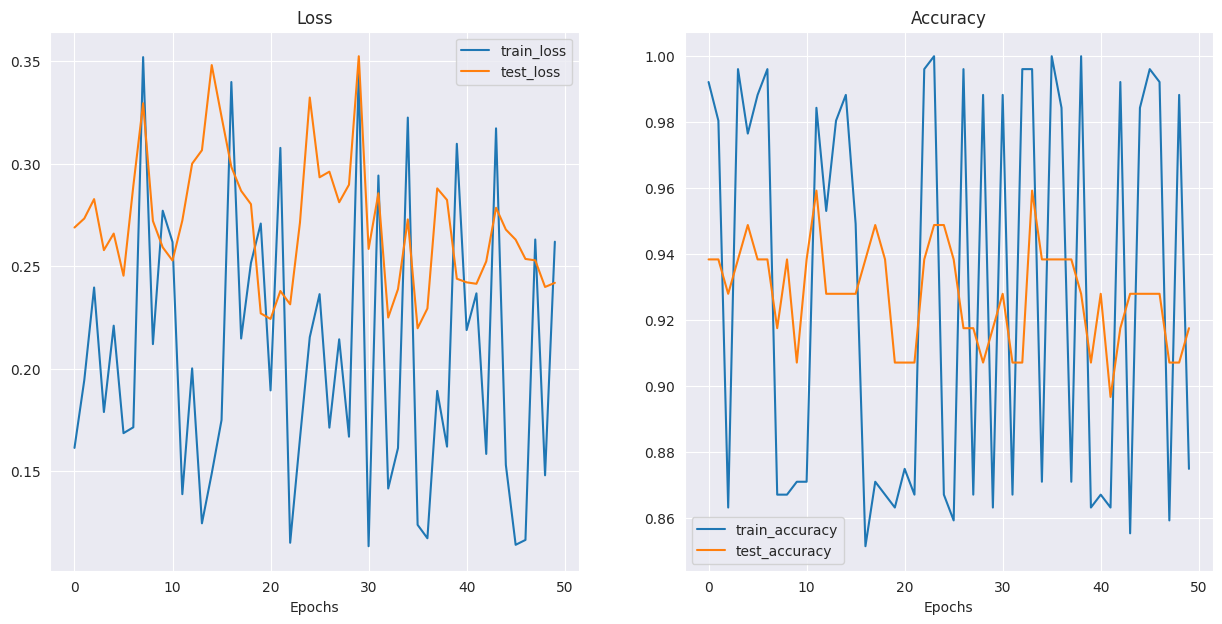

In [43]:
from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [46]:
# start timer
from timeit import default_timer as Timer
start_timer = Timer()

# setup traning and svae result and model Auto transform data

results , model_effienvtnet_v1 = model_engine(
    model=model,
    train_dataloader=train_data_loader_auto,
    test_dataloader=test_data_loader_auto,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50,
    device=device
)

torch.save(obj=model.state_dict(),f='Models/efficientnet_auto.pth')
# End the timer and print out how long it took
end_time = Timer()
print(f"[INFO] Total training time: {end_time-start_timer:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Train_loss: 0.1993 | Train_acc: 0.8672 | Test_loss: 0.3933 | Test_acc: 0.8456
Epoch: 2 | Train_loss: 0.2165 | Train_acc: 0.8672 | Test_loss: 0.3777 | Test_acc: 0.8456
Epoch: 3 | Train_loss: 0.2111 | Train_acc: 0.9688 | Test_loss: 0.3453 | Test_acc: 0.8456
Epoch: 4 | Train_loss: 0.2294 | Train_acc: 0.8516 | Test_loss: 0.3643 | Test_acc: 0.8456
Epoch: 5 | Train_loss: 0.3085 | Train_acc: 0.8516 | Test_loss: 0.3355 | Test_acc: 0.8456
Epoch: 6 | Train_loss: 0.1365 | Train_acc: 0.9688 | Test_loss: 0.3545 | Test_acc: 0.8561
Epoch: 7 | Train_loss: 0.1389 | Train_acc: 0.9844 | Test_loss: 0.3773 | Test_acc: 0.8352
Epoch: 8 | Train_loss: 0.3963 | Train_acc: 0.8594 | Test_loss: 0.4120 | Test_acc: 0.8456
Epoch: 9 | Train_loss: 0.1727 | Train_acc: 0.9883 | Test_loss: 0.3972 | Test_acc: 0.8665
Epoch: 10 | Train_loss: 0.1215 | Train_acc: 0.9727 | Test_loss: 0.4445 | Test_acc: 0.8362
Epoch: 11 | Train_loss: 0.2423 | Train_acc: 0.8711 | Test_loss: 0.4245 | Test_acc: 0.8466
Epoch: 12 | Train_l

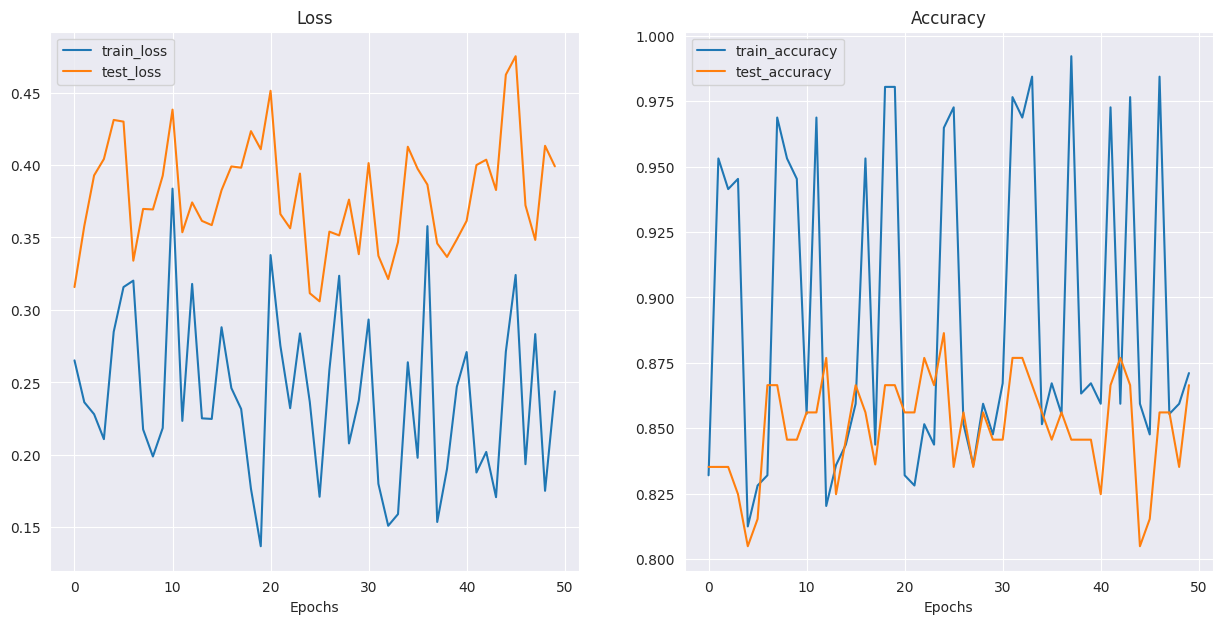

In [45]:
from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# Make predictions on images from the test set
One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in same format as the images our model was trained on.

This means we'll need to make sure our images have:

Same shape - If our images are different shapes to what our model was trained on, we'll get shape errors.
Same datatype - If our images are a different datatype (e.g. torch.int8 vs. torch.float32) we'll get datatype errors.
Same device - If our images are on a different device to our model, we'll get device errors.
Same transformations - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make predictions on images transformed in a different way, these predictions may be off.

In [48]:
from typing import List, Tuple
from PIL import Image
def pred_and_plot_image(
    model: nn.Module,
    image_path: str,
    class_names: List[str],
    transform: torchvision.transforms = None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"
):

  img = Image.open(image_path)

  if transform is not None:
    image_transform = transform
  else:
    image_transform = weights.transforms()

    # predict on test image
    model.to(device)

    # model to eval mode
    model.eval()
    with torch.inference_mode():
      # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)
      # prediction
      target_image_pred = model(transformed_image.to(device))

    # prediction probs and conver into label
    target_image_pred_label = torch.argmax(torch.softmax(target_image_pred,dim=1))
    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {torch.softmax(target_image_pred,dim=1).max():.3f}")
    plt.axis(False);

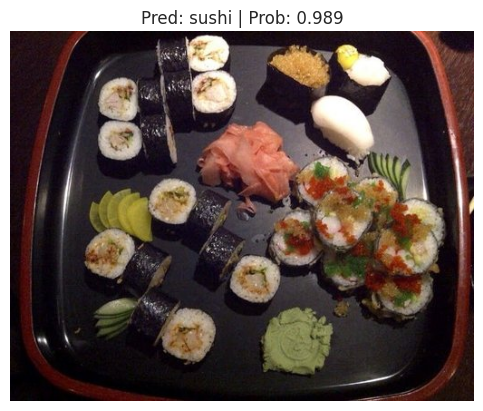

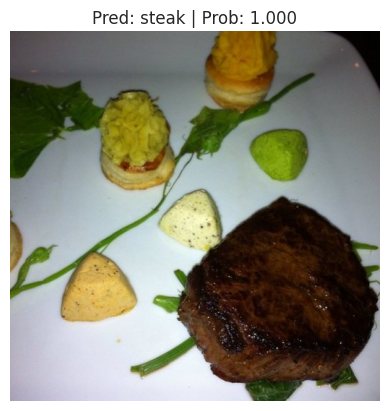

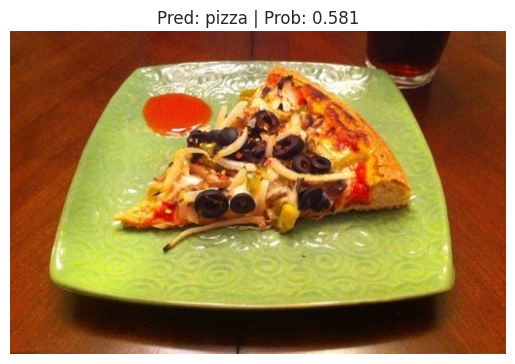

In [52]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=num_classes,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                       )

## Making predictions on a custom image

data/04-pizza-dad.jpeg already exists, skipping download.


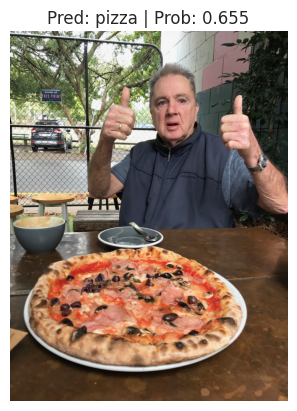

In [54]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=num_classes)